In [2]:
import csv
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [3]:

def read_csv(file_path):
    x_coords_obj1 = []
    y_coords_obj1 = []
    x_coords_obj2 = []
    y_coords_obj2 = []
    frames = []

    with open(file_path, mode="r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header

        for row in reader:
            frame = int(row[0])
            x1, y1 = row[1], row[2]
            x2, y2 = row[3], row[4]

            frames.append(frame)

            if x1 != 'None' and y1 != 'None':
                x_coords_obj1.append(float(x1))
                y_coords_obj1.append(float(y1))

            if x2 != 'None' and y2 != 'None':
                x_coords_obj2.append(float(x2))
                y_coords_obj2.append(float(y2))

    return frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2


In [4]:
def calc_R(xc, yc, x, y):
    return np.sqrt((x - xc)**2 + (y - yc)**2)
# Iterative circle fitting with angular binning
def fit_circle_iterative(x_coords, y_coords, num_bins=36, max_iter=10, tol=1e-6):
    # Initial guess for center (mean of points)
    xc, yc = np.mean(x_coords), np.mean(y_coords)
    prev_center = (xc, yc)
    
    for iteration in range(max_iter):
        # Calculate distances and approximate angles from the current center
        angles = np.arctan2(y_coords - yc, x_coords - xc)
        
        # Bin the points by angles
        bins = np.linspace(-np.pi, np.pi, num_bins + 1)
        bin_indices = np.digitize(angles, bins)
        
        # Sample one representative point per bin
        sampled_x = []
        sampled_y = []
        for b in range(1, len(bins)):
            bin_points = (bin_indices == b)
            if np.any(bin_points):
                sampled_x.append(np.mean(x_coords[bin_points]))
                sampled_y.append(np.mean(y_coords[bin_points]))
        
        sampled_x = np.array(sampled_x)
        sampled_y = np.array(sampled_y)
        
        # Fit the circle using the sampled points
        result = least_squares(func_to_optimize, [xc, yc], args=(sampled_x, sampled_y))
        xc, yc = result.x
        
        # Check for convergence
        if np.linalg.norm([xc - prev_center[0], yc - prev_center[1]]) < tol:
            break
        prev_center = (xc, yc)
    
    # Final radius calculation
    Ri = calc_R(xc, yc, sampled_x, sampled_y)
    R = Ri.mean()
    return (xc, yc), R

# Update the calculate_centers function to use the iterative fitting method
def calculate_centers(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2):
    center_obj1, radius_obj1 = fit_circle_iterative(x_coords_obj1, y_coords_obj1, num_bins=36)
    center_obj2, radius_obj2 = fit_circle_iterative(x_coords_obj2, y_coords_obj2, num_bins=36)
    return center_obj1, center_obj2, radius_obj1, radius_obj2


In [5]:

# Function to calculate angles for both objects
def calculate_angles(frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2, center_obj1, center_obj2):
    angles_obj1 = []
    angles_obj2 = []

    for x1, y1, x2, y2 in zip(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2):
        # Calculate angle for object 1
        angle1 = np.arctan2(y1 - center_obj1[1], x1 - center_obj1[0])
        angles_obj1.append(angle1)

        # Calculate angle for object 2
        angle2 = np.arctan2(y2 - center_obj2[1], x2 - center_obj2[0])
        angles_obj2.append(angle2)

    return angles_obj1, angles_obj2

# Function to calculate velocities for both objects
# Function to calculate velocities for both objects (absolute value)
def calculate_velocities(frames, angles_obj1, angles_obj2):
    np_angles_obj1 = np.array(angles_obj1[::6])
    np_angles_obj2 = np.array(angles_obj2[::6])
    np_frames = np.array(frames[::6])

    angle_v1 = []
    angle_v2 = []
    angle_forv1 = []
    angle_forv2 = []

    for i in range(len(np_frames) - 1):
        delta_t = np_frames[i + 1] - np_frames[i]
        delta_x1 = (np_angles_obj1[i + 1] - np_angles_obj1[i])
        delta_x2 = (np_angles_obj2[i + 1] - np_angles_obj2[i])

        # Adjust for angular wrapping (ensure continuity)
        if delta_x1 > np.pi:
            delta_x1 -= 2 * np.pi
        elif delta_x1 < -np.pi:
            delta_x1 += 2 * np.pi

        if delta_x2 > np.pi:
            delta_x2 -= 2 * np.pi
        elif delta_x2 < -np.pi:
            delta_x2 += 2 * np.pi

        # Calculate angular velocities
        v1 = delta_x1 / delta_t
        v2 = delta_x2 / delta_t

        # Append absolute velocities
        angle_v1.append(np.abs(v1))
        angle_v2.append(np.abs(v2))
        angle_forv1.append(np_angles_obj1[i])
        angle_forv2.append(np_angles_obj2[i])

    # Convert to NumPy arrays for easier processing
    angle_v1 = np.array(angle_v1)
    angle_v2 = np.array(angle_v2)

    # Dynamically detect and remove outliers using IQR (Interquartile Range)
    def filter_outliers(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return np.where((data < lower_bound) | (data > upper_bound), np.nan, data)

    # Apply outlier filtering
    angle_v1 = filter_outliers(angle_v1)
    angle_v2 = filter_outliers(angle_v2)

    # Remove NaN entries for consistent plotting
    valid_idx1 = ~np.isnan(angle_v1)
    valid_idx2 = ~np.isnan(angle_v2)
    angle_v1 = angle_v1[valid_idx1]
    angle_v2 = angle_v2[valid_idx2]
    angle_forv1 = np.array(angle_forv1)[valid_idx1]
    angle_forv2 = np.array(angle_forv2)[valid_idx2]

    return angle_v1, angle_v2, angle_forv1, angle_forv2


In [12]:

def plot_results(frames, angles_obj1, angles_obj2, angle_forv1, angle_v1, angle_forv2, angle_v2):
    minuites = [frame / 3600 for frame in frames]

    interval_size = np.pi / 8
    angle_bins = np.arange(-np.pi, np.pi, interval_size)
    avg_velocity1 = []
    avg_velocity2 = []

    for i in range(len(angle_bins) - 1):
        mask1 = (angle_forv1 >= angle_bins[i]) & (angle_forv1 < angle_bins[i + 1])
        if np.any(mask1):
            avg_velocity1.append(np.mean(angle_v1[mask1]))
        else:
            avg_velocity1.append(None)
        
        mask2 = (angle_forv2 >= angle_bins[i]) & (angle_forv2 < angle_bins[i + 1])
        if np.any(mask2):
            avg_velocity2.append(np.mean(angle_v2[mask2]))
        else:
            avg_velocity2.append(None)

    fig, axs = plt.subplots(4, 1, figsize=(6, 16))

    # Plot angles
    axs[0].plot(minuites, angles_obj1, label="Object 1 Angle (radians)", color="blue")
    axs[0].plot(minuites, angles_obj2, label="Object 2 Angle (radians)", color="green")
    axs[0].set_xlabel("Time (minutes)")
    axs[0].set_ylabel("Angle (radians)")
    axs[0].set_title("Angles of Tracked Objects Over Time")
    axs[0].legend()
    axs[0].grid(True)

    # Scatter plot of angular velocity with moving average for Object 1
    axs[1].scatter(angle_forv1, angle_v1, label="Object 1 Velocity")
    axs[1].plot((angle_bins[:-1] + angle_bins[1:]) / 2, avg_velocity1, color='red', label="Object 1 Moving Average (pi/8)", linestyle='-', marker='o')
    axs[1].set_xlabel("Angle (radians)")
    axs[1].set_ylabel("Angular Velocity")
    axs[1].set_title("Object 1 Velocity over Angle with Moving Average")
    axs[1].legend()
    axs[1].grid(True)

    # Scatter plot of angular velocity with moving average for Object 2
    axs[2].scatter(angle_forv2, angle_v2, label="Object 2 Velocity")
    axs[2].plot((angle_bins[:-1] + angle_bins[1:]) / 2, avg_velocity2, color='red', label="Object 2 Moving Average (pi/8)", linestyle='-', marker='o')
    axs[2].set_xlabel("Angle (radians)")
    axs[2].set_ylabel("Angular Velocity")
    axs[2].set_title("Object 2 Velocity over Angle with Moving Average")
    axs[2].legend()
    axs[2].grid(True)
    plt.tight_layout()
    plt.show()

Calculated center for Object 1: (546.5799666825801, 427.46465919548416)
Calculated radius for Object 1: 305.65229436531
Calculated center for Object 2: (1291.9575602993916, 424.72517145944977)
Calculated radius for Object 2: 290.5101109895381


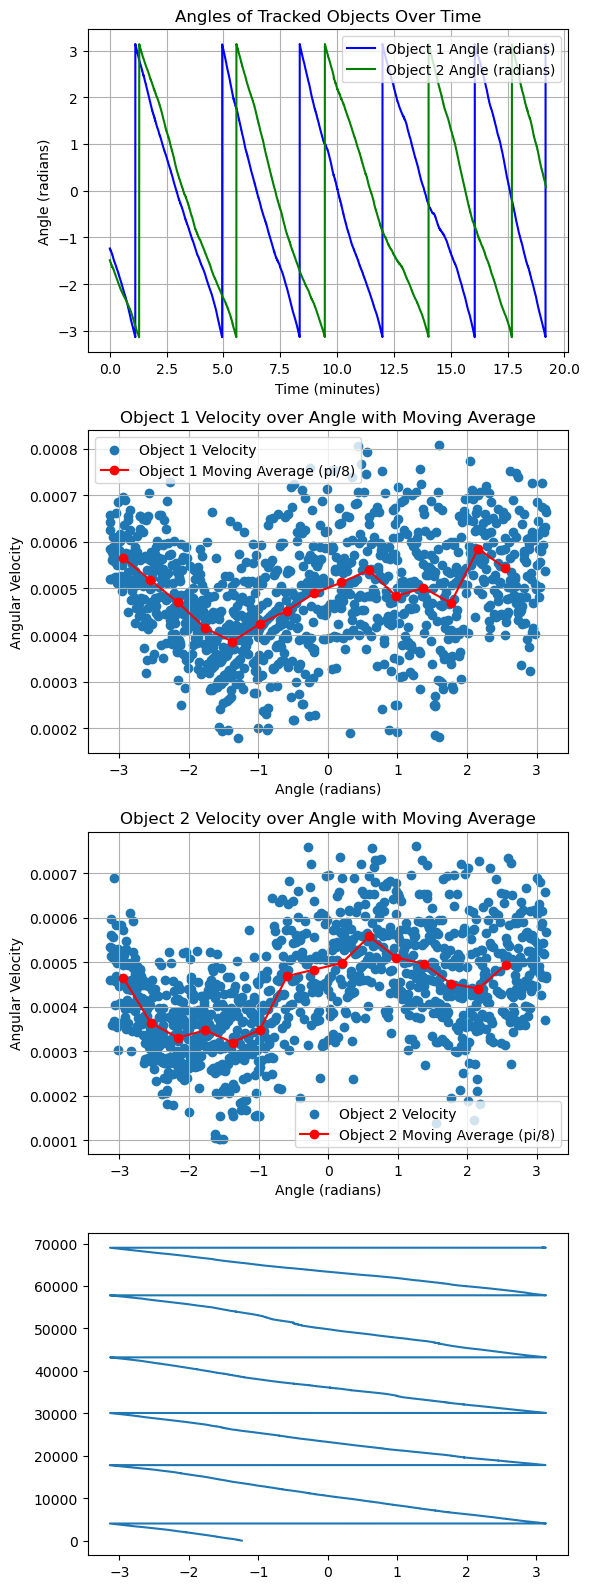

In [ ]:

#file_path = R"C:\Users\avsha\Downloads\S6120009_data.csv"
file_path = R"C:\Users\avsha\Documents\GitHub\Ants\object_tracking_coordinates.csv"

frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2 = read_csv(file_path)

# Calculate centers
center_obj1, center_obj2, radius_obj1, radius_obj2 = calculate_centers(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2)
print(f"Calculated center for Object 1: {center_obj1}")
print(f"Calculated radius for Object 1: {radius_obj1}")
print(f"Calculated center for Object 2: {center_obj2}")
print(f"Calculated radius for Object 2: {radius_obj2}")
# Calculate angles
angles_obj1, angles_obj2 = calculate_angles(frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2, center_obj1, center_obj2)

# Calculate velocities
angle_v1, angle_v2, angle_forv1, angle_forv2 = calculate_velocities(frames, angles_obj1, angles_obj2)

# Plot results
plot_results(frames, angles_obj1, angles_obj2, angle_forv1, angle_v1, angle_forv2, angle_v2)


